In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import RFECV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [2]:
train_csv = pd.read_csv("train_old.csv")
test_csv = pd.read_csv("test_old.csv")

In [3]:
y_temp = train_csv["target"]
x_temp = train_csv.drop(["id", "target"], axis = 1)

In [4]:
#Recursive feature elimination with cross validation
estimator = LogisticRegression()   
rfecv = RFECV(estimator=estimator, step=1, cv=5,scoring='accuracy') 
rfecv = rfecv.fit(x_temp, y_temp)

col_rfecv = x_temp.columns[rfecv.support_]
print('Optimal number of features :', rfecv.n_features_)
print('Best features :', col_rfecv)

Optimal number of features : 6
Best features : Index(['33', '65', '73', '91', '199', '217'], dtype='object')


In [5]:
x = train_csv[col_rfecv].values
test = test_csv[col_rfecv].values
y = train_csv['target']

In [6]:
scaler = RobustScaler()
x_final = scaler.fit_transform(x)
test_final = scaler.fit_transform(test)
x_final = pd.DataFrame(x_final)
test_final = pd.DataFrame(test_final)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(x_final, y, test_size=0.15, random_state = 42) 

In [11]:
#####LogisticRegression

In [12]:
estimator_LR = LogisticRegression()
C= np.arange(0.05, 1, 0.05).round(2).tolist()
param_grid = {
    'solver':['newton-cg', 'lbfgs', 'liblinear'],
    'penalty':['l2'],
    'C':C}
grid = GridSearchCV(estimator_LR, param_grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_search=grid.fit(X_train, y_train)
print("Best Parameters: " + str(grid_search.best_params_))
accuracy_LR = grid_search.best_score_ *100
print("Accuracy for our training dataset with tuning is : {:.2f}%".format(accuracy_LR))
best_solver = grid_search.best_params_['solver']
best_penalty = grid_search.best_params_['penalty']
best_C = grid_search.best_params_['C']

Best Parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Accuracy for our training dataset with tuning is : 76.32%


In [13]:
LR = LogisticRegression(solver=best_solver , C =best_C , penalty=best_penalty)
LR.fit(X_train, y_train) 
ypred_LR = LR.predict_proba(test_final)[:,1]

In [14]:
#####SVC

In [15]:
estimator_SVC = SVC()
C= np.arange(0.05, 1, 0.05).round(2).tolist()
param_grid = {
    'kernel' : ['linear','poly','rbf', 'sigmoid'],
    'C':C}
grid = GridSearchCV(estimator_SVC, param_grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_search=grid.fit(X_train, y_train)
print("Best Parameters: " + str(grid_search.best_params_))
accuracy_SVC = grid_search.best_score_ *100
print("Accuracy for our training dataset with tuning is : {:.2f}%".format(accuracy_SVC))
best_kernel = grid_search.best_params_['kernel']
best_C = grid_search.best_params_['C']

Best Parameters: {'C': 0.25, 'kernel': 'sigmoid'}
Accuracy for our training dataset with tuning is : 77.59%


In [16]:
SVC= SVC(C=best_C,kernel= best_kernel, probability=True)
SVC.fit(X_train, y_train) 
ypred_SVC = SVC.predict_proba(test_final)[:,1]

Text(0.5, 1.0, 'Results of Hybrid')

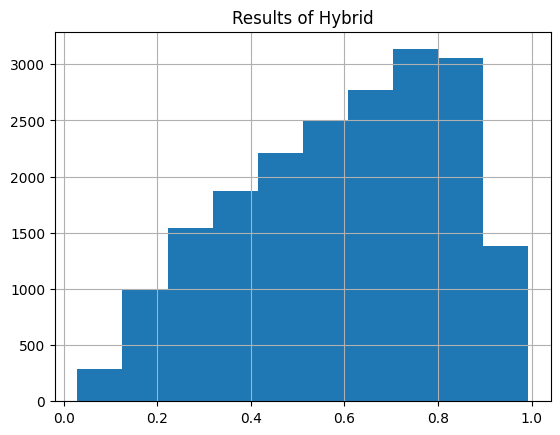

In [34]:
final_preds = ( ypred_SVC * 0.4 + ypred_LR  * 0.6 )
output_BC = pd.DataFrame({'id':range(250, 20000),'target': final_preds})
output_BC.to_csv('submission_HB.csv', index=False)
output_BC['target'].hist().set_title("Results of Hybrid")